In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
df = pd.read_csv('08/mercari/train.tsv', sep='\t')
print(df.shape)
df.head()

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


- 여기서 수행할 것은 지도학습(회귀)이며, 다른 data들을 이용하여 'price'를 예측하는 것!
- 다른 점은 'item_description'이라고 하는 텍스트 칼럼 또한 이 예측에 활용함.

In [42]:
#결측값, 기본정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


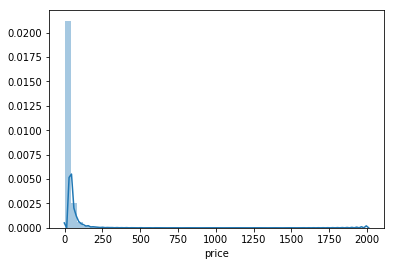

In [43]:
#target 값의 데이터 분포도 확인
sns.distplot(df['price'])

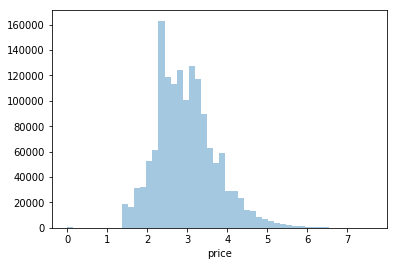

In [44]:
#왜곡이 많이 되어있으므로, 로그변환을 통해 데이터 분포를 정규분포로 바꾸기
df['price'] = np.log1p(df['price'])
sns.distplot(df['price'], kde=False) #kde=False로 하면 정규분포 곡선이 출력되지 않음.

- 참고) kde는 kernel distribution estimator의 약자로, 확률밀도함수를 추정하는 것임.
- sns.kdeplot으로 확인할수있고, / sns.distplot은 히스토그램과 kde를 같이 그려주는 것!
- https://pinkwink.kr/984

In [45]:
df['price'].head()

0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64

In [46]:
#df의 범주형 변수인 'shipping'(배송비 0/1), 'item_condition_id'(제품상태 1~5) 를 분포 확인
print(df['shipping'].value_counts())
print(df['item_condition_id'].value_counts())

0    819435
1    663100
Name: shipping, dtype: int64
1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [47]:
#우리가 텍스트 분석을 하려는 칼럼 'item_description'은 결측값이 별로 없지만(4개), 별도 설명이 없으면 'No description yet'으로 되어있음.
df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [48]:
df[df['item_description']=='No description yet']['item_description'].count() #결측값은 4건뿐이나 이렇게 아무 설명도 없는 것들도 결측값과 마찬가지임. 
                                                                                                                        #값이 아주 많음..

82489

In [49]:
#df의 'category_name'의 현황: 결측값 다수 존재, 대분류/중분류/소분류로 되어 있음. 이 칼럼에 함수를 적용하여 칼럼3개를 만듦(대/중/소 칼럼)
df['category_name'].head()

0                                    Men/Tops/T-shirts
1    Electronics/Computers & Tablets/Components & P...
2                          Women/Tops & Blouses/Blouse
3                   Home/Home Décor/Home Décor Accents
4                              Women/Jewelry/Necklaces
Name: category_name, dtype: object

In [4]:
def split_cat(category_name):
    try:
        return category_name.split('/') #결측값이 아니라면 '/'기호 기준으로 split하여 3개 칼럼반환
    except:
        return ['Other_Null','Other_Null','Other_Null'] #결측값이라면 전부(3개 칼럼 모두) 'Other_Null' 을 반환

In [5]:
#위의 함수 적용: zip과 *를 apply lambda 식에 적용! ==>칼럼 3개가 반환됨.
df['cat_dae'], df['cat_jung'], df['cat_so'] = zip(*df['category_name'].apply(lambda x: split_cat(x)))
df.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_dae,cat_jung,cat_so
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse


In [5]:
#분포 정도 파악
print('\n대분류: \n', df['cat_dae'].value_counts())
print('\n중분류: \n', df['cat_jung'].value_counts())
print('\n소분류: \n', df['cat_so'].value_counts())


대분류: 
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64

중분류: 
 Athletic Apparel             134383
Makeup                       124624
Tops & Blouses               106960
Shoes                        100452
Jewelry                       61763
Toys                          58158
Cell Phones & Accessories     53290
Women's Handbags              45862
Dresses                       45758
Women's Accessories           42350
Jeans                         36130
Video Games & Consoles        35971
Sweaters                      35752
Underwear                     33784
Skin Care                     29838
Home Décor                    25188
Fragrance        

In [6]:
print(df['cat_dae'].nunique())
print(df['cat_jung'].nunique())
print(df['cat_so'].nunique())

11
114
871


In [6]:
#결측값 처리 -category, brand_name, item_description 전부 null값을 'Other_Null'로 동일하게 변경!
df['category_name'].fillna('Other_Null', inplace=True) #아까 대/중/소 칼럼은 결측값의 경우 'Other Null'로 되어있으므로 이 세개 칼럼에 대해선 노상관.
df['brand_name'].fillna('Other_Null', inplace=True)
df['item_description'].fillna('Other_Null', inplace=True)

In [7]:
df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

- df의 문자열 칼럼 -> 숫자형으로 바꾸기 // 하나씩 컬럼을 살펴본 후, 맨 마지막에 일괄적용

In [56]:
df.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
cat_dae               object
cat_jung              object
cat_so                object
dtype: object

In [59]:
#brand_name(상품의 브랜드명) 데이터 분포 --> 유니크한 것의 개수가 4810개로 많아 보이지만 '원-핫인코딩 변환.'
        #brand_name은 price에 많은 영향을 끼치는 것으로 보임. 원핫인코딩 시 brand중 어떤 브랜드가 특히 영향을 많이 미치는지?를 볼수있음.
print(df['brand_name'].nunique()) #unique한 네임이 4810개.
print(df['brand_name'].value_counts()[:5]) #가장많은 이름은 결측값.

4810
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


In [60]:
#name(제품명) --> 텍스트가 짧고, 유형이 많으므로 'count기반 벡터화.'
print(df['name'].nunique()) #unique한 네임이 122만여개로 매우 많음(전체 데이터가 148만개임)
print(df['name'].value_counts()[:5]) #특출나게 많이 쏠려 있는 네임이 있는 것은 아님.

1225273
Bundle      2232
Reserved     453
Converse     445
BUNDLE       418
Dress        410
Name: name, dtype: int64


In [ ]:
#cat_dae, jung, so --> 원-핫 인코딩 적용
#shipping(배송비): 0/1 --> 원-핫 인코딩 적용
#item_condition_id(제품 상태): 1~5 --> 원-핫 인코딩 적용(왜냐면 숫자가 값을 가질 수 있기 때문.)

In [8]:
#item_description(제품 설명): 평균 문자가 145자 정도로 큰 편이므로 tf-idf 적용.
print('평균 문자열 크기: ', df['item_description'].str.len().mean())
print('예시 2개 \n', df['item_description'][:2])

평균 문자열 크기:  145.7113889385411
예시 2개 
 0                                   No description yet
1    This keyboard is in great condition and works ...
Name: item_description, dtype: object


- 문자열 전처리 일괄적용

In [9]:
#피처벡터화(name: count, item_description: tfidf)
cnt_vect = CountVectorizer()
X_name = cnt_vect.fit_transform(df['name'])
print(X_name.shape)

(1482535, 105757)


In [11]:
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english') #책에선 max_features=50000인데 너무 오래 걸려서 만으로 줄임
X_desc = tfidf.fit_transform(df['item_description'])
print(X_desc.shape)

(1482535, 10000)


In [10]:
#원핫인코딩(원래 사용하던 OneHotEncoder 외에 LabelBinarizer를 사용하면 원-핫인코딩+희소행렬 변환 가능!)
    #왜냐면 피처벡터결과 희소행렬 & 원핫인코딩결과 희소행렬을 나중에 hstack으로 붙이기 위함.(모두 희소행렬로만 만들기 위해)
from sklearn.preprocessing import LabelBinarizer

#brand_name, item_condition_id, shipping, dae/jung/so에 대해 진행
lb_brand = LabelBinarizer(sparse_output=True) #sparse_output=True면 희소행렬 반환한다는 뜻
X_brand = lb_brand.fit_transform(df['brand_name'])

lb_con = LabelBinarizer(sparse_output=True) 
X_con = lb_con.fit_transform(df['item_condition_id'])

lb_ship = LabelBinarizer(sparse_output=True) 
X_ship = lb_ship.fit_transform(df['shipping'])

lb_dae = LabelBinarizer(sparse_output=True) 
X_dae = lb_dae.fit_transform(df['cat_dae'])

lb_jung = LabelBinarizer(sparse_output=True) 
X_jung = lb_jung.fit_transform(df['cat_jung'])

lb_so = LabelBinarizer(sparse_output=True) 
X_so = lb_so.fit_transform(df['cat_so'])

#반환결과, 모든 type은 csr matrix임. 하나만 보자
print(type(X_brand))

#나머지 shape을 출력
print(X_brand.shape, X_con.shape, X_ship.shape)
print(X_dae.shape, X_jung.shape, X_so.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(1482535, 4810) (1482535, 5) (1482535, 1)
(1482535, 11) (1482535, 114) (1482535, 871)


In [17]:
#만들어진 피처벡터+원핫인코딩벡터를 hstack으로 결합
import gc
gc.collect()

13

In [18]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_desc, X_brand, X_con, X_ship, X_dae, X_jung, X_so) #아까 만든 것들 리스트
X_sparse = hstack(sparse_matrix_list).tocsr() #총 결합 피처
print(type(X_sparse), X_sparse.shape)

#위에 출력만 하고 이게 메모리를 많이 차지하므로 사용목적 끝났으면 바로 삭제
del X_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 121569)


0

### 머신러닝 회귀 모델에 적용 - 릿지, LightGBM
- 릿지

In [36]:
#평가지표: RMSLE
def rmsle(y, pred):
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(pred), 2)))

#우리가 앞에서 타겟값인 'price'에 로그변환을 했었으므로, 지도학습 시 실제값인 y_test뿐 아니라 예측된 pred 값또한 로그변환된 값이 반환됨.
#원본으로 지수변환시킨 후, RMSLE 함수를 적용해야 함
def evaluate_org_price(y_test, preds):
    #로그변환값->원래값으로 변환.
    pred_exp = np.expm1(preds)
    y_test_exp = np.expm1(y_test)
    
    #다시 위의 함수를 적용
    result = rmsle(y_test_exp, pred_exp)
    rmsle_result = np.round(result, 3)
    return rmsle_result

In [37]:
#회귀- 릿지(지도학습) 하는 함수
import gc
gc.collect()
from scipy.sparse import hstack

def model_train_predict(model, X_list):
    
    X = hstack(X_list).tocsr() #들어온 X_list들을 희소행렬화
    X_train, X_test, y_train, y_test = train_test_split(X, df['price'], test_size=.2, random_state=156)
    
    #모델 학습 및 예측
    #객체-이미 만들어져있음
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    
    #메모리 삭제(용량 많이 잡아먹어서,,ㅠㅠ)
    del X, X_train, X_test, y_train
    gc.collect()
    
    return y_test, preds #반환값은 실제값(y_test)와 예측값(preds)만
    

In [27]:
#객체
linear_model = Ridge(solver='lsqr', fit_intercept=False)

#desc 포함 안한 경우 rmsle
X_list = (X_name, X_brand, X_con, X_ship, X_dae, X_jung, X_so)
y_test, preds = model_train_predict(linear_model, X_list)
print(evaluate_org_price(y_test, preds))

inf


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in expm1
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
#desc 포함한 경우 rmsle
X_list = (X_desc, X_name, X_brand, X_con, X_ship, X_dae, X_jung, X_so)
y_test, ridge_preds = model_train_predict(linear_model, X_list) #여기 결과는 ridge_preds
print(evaluate_org_price(y_test, ridge_preds))

inf


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in expm1
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
import gc
gc.collect()

0

- LightGBM

In [38]:
from lightgbm import LGBMRegressor

X_list = (X_desc, X_name, X_brand, X_con, X_ship, X_dae, X_jung, X_so)
#객체-n_estimators를 많이 늘리면 좋지만 메모리 문제로 인해 200으로만 진행
lgbm = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156) 
#rmsle 결과
y_test, lgbm_preds = model_train_predict(lgbm, X_list) #여기 결과는 lgbm_preds
print(evaluate_org_price(y_test, lgbm_preds))

inf


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in expm1
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in expm1
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


- 앙상블 모델(릿지:0.55, lgbm:0.45 가중치) ==> 최종 성능 가장 뛰어남!

In [39]:
preds = lgbm_preds*0.45 + ridge_preds*0.55
print(evaluate_org_price(y_test, preds))

inf


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in expm1
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in expm1
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
